In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
df = pd.read_csv("internet_access_data.csv")
df.drop(columns = ["Flag Codes"], inplace = True)
df.head(100)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,BEL,INTERNET,TOT,PC_HH,A,2005,50.157500
1,BEL,INTERNET,TOT,PC_HH,A,2006,53.959700
2,BEL,INTERNET,TOT,PC_HH,A,2007,60.164000
3,BEL,INTERNET,TOT,PC_HH,A,2008,63.627600
4,BEL,INTERNET,TOT,PC_HH,A,2009,67.435200
...,...,...,...,...,...,...,...
95,FRA,INTERNET,TOT,PC_HH,A,2013,81.719200
96,FRA,INTERNET,TOT,PC_HH,A,2014,82.955600
97,FRA,INTERNET,TOT,PC_HH,A,2015,82.620700
98,FRA,INTERNET,TOT,PC_HH,A,2016,85.873600


In [178]:
df.isna().sum().any()

np.False_

In [47]:
df.loc[df["LOCATION"] == "PAK"]

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value


In [177]:
df["LOCATION"].value_counts().head(25)

LOCATION
BEL    15
DNK    15
DEU    15
AUT    15
CZE    15
POL    15
NLD    15
CRI    15
LTU    15
ESP    15
FIN    15
IRL    15
GRC    15
NOR    15
KOR    15
MEX    15
GBR    15
PRT    15
SVN    15
ITA    15
LUX    15
HUN    15
SVK    15
SWE    15
LVA    15
Name: count, dtype: int64

In [174]:
df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,BEL,INTERNET,TOT,PC_HH,A,2005,50.157500
1,BEL,INTERNET,TOT,PC_HH,A,2006,53.959700
2,BEL,INTERNET,TOT,PC_HH,A,2007,60.164000
3,BEL,INTERNET,TOT,PC_HH,A,2008,63.627600
4,BEL,INTERNET,TOT,PC_HH,A,2009,67.435200
...,...,...,...,...,...,...,...
510,CRI,INTERNET,TOT,PC_HH,A,2015,60.181183
511,CRI,INTERNET,TOT,PC_HH,A,2016,64.800000
512,CRI,INTERNET,TOT,PC_HH,A,2017,68.600000
513,CRI,INTERNET,TOT,PC_HH,A,2018,73.080247


Text(0, 0.5, 'Internet Access Score')

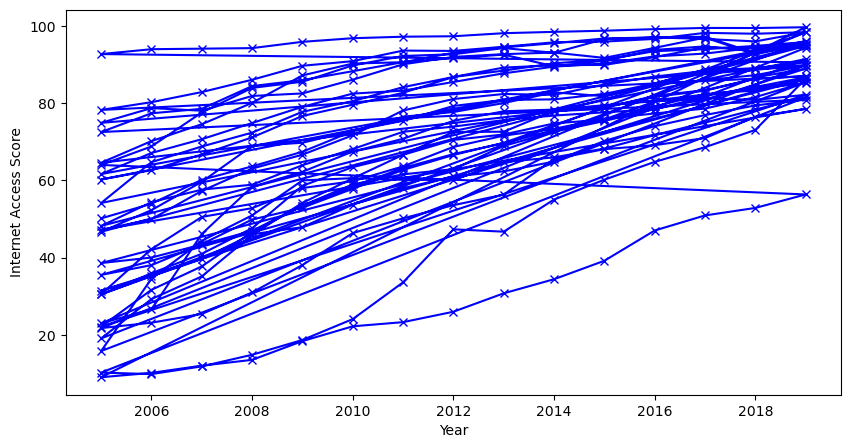

In [175]:
x = df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]["TIME"]
y = df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]["Value"]
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='x', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Internet Access Score')

In [ ]:
def create_dataset(dataset, bucket):
    X, y = [], []
    for i in range(len(dataset) - bucket):
        X.append(dataset[i: i + bucket])
        y.append(dataset[i + bucket])
    return np.array(X), np.array(y)

In [65]:
a = df[df["LOCATION"] == "BEL"]["Value"].values
print(a)
split_idx = int(len(a) * 0.75)
bucket = 3
X_train, y_train = create_dataset(a[:split_idx], bucket)
X_test, y_test = create_dataset(a[split_idx:], bucket)

[50.1575  53.9597  60.164   63.6276  67.4352  72.7371  76.5078  77.7137
 80.0478  82.8041  81.825   84.7857  85.96844 87.27254 89.73015]


In [64]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8, 3) (8,)
(1, 3) (1,)


In [87]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=1, shuffle=False)

In [88]:
next(iter(train_loader))

[tensor([[53.9597, 60.1640, 63.6276]]), tensor([67.4352])]

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 22, num_layers = 2, output_size = 1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size = 22, num_layers = 2, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size = 22, num_layers = 2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        x = self.relu(x)
        return x


In [162]:
model = LSTM()

In [163]:
from torchinfo import summary
summary(model, input_size=(1, 3, 1), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 1]                    --
├─LSTM: 1-1                              [1, 3, 22]                6,248
├─LSTM: 1-2                              [1, 3, 22]                8,096
├─Linear: 1-3                            [1, 1]                    23
├─ReLU: 1-4                              [1, 1]                    --
Total params: 14,367
Trainable params: 14,367
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

In [164]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [165]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs=50):
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
            output = model(X_batch) # Forward pass
            loss = criterion(output, y_batch)

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        #print(f"Epoch {epoch+1}/{epochs}, Average Loss: {epoch_loss/len(train_loader):.4f}")
        losses.append(epoch_loss / len(train_loader))

    
        if(epoch % 10 == 0):
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
                    output = model(X_batch)
                    loss = criterion(output, y_batch)
                    test_loss += loss.item()
            print(f"Epoch number: {epoch} Training Loss: {epoch_loss / len(train_loader):.4f} Test Loss: {test_loss / len(test_loader):.4f}")
    return losses


In [166]:
losses = train(model, criterion, optimizer, train_loader, test_loader, epochs=100)

Epoch number: 0 Training Loss: 806.2614 Test Loss: 7713.2622
Epoch number: 10 Training Loss: 458.3346 Test Loss: 4524.5884
Epoch number: 20 Training Loss: 225.0535 Test Loss: 2697.8708
Epoch number: 30 Training Loss: 97.8139 Test Loss: 1588.4608
Epoch number: 40 Training Loss: 71.7045 Test Loss: 947.1495
Epoch number: 50 Training Loss: 0.4009 Test Loss: 588.1158
Epoch number: 60 Training Loss: 18.6046 Test Loss: 402.4568
Epoch number: 70 Training Loss: 7.5305 Test Loss: 303.4324
Epoch number: 80 Training Loss: 0.9180 Test Loss: 253.4272
Epoch number: 90 Training Loss: 0.4638 Test Loss: 229.2210


C:\Users\natha\AppData\Local\Temp\ipykernel_12832\489916841.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


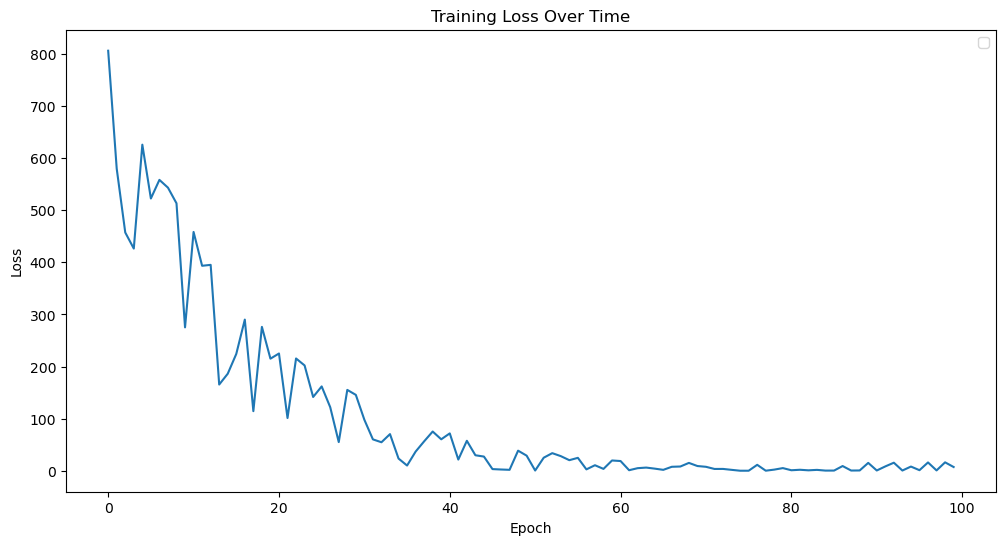

In [167]:
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [183]:
ls = df["LOCATION"].value_counts().head(25).index
ls

Index(['BEL', 'DNK', 'DEU', 'AUT', 'CZE', 'POL', 'NLD', 'CRI', 'LTU', 'ESP',
       'FIN', 'IRL', 'GRC', 'NOR', 'KOR', 'MEX', 'GBR', 'PRT', 'SVN', 'ITA',
       'LUX', 'HUN', 'SVK', 'SWE', 'LVA'],
      dtype='object', name='LOCATION')

[74.9174   78.7298   78.0544   81.8811   82.534    86.0984   90.0828
 91.9976   92.7135   93.1202   91.74     94.3436   97.00071  92.66406
 95.434314]
Country DNK
Epoch number: 0 Training Loss: 139.3553 Test Loss: 1279.8695
Epoch number: 10 Training Loss: 1.6998 Test Loss: 80.6732
Epoch number: 20 Training Loss: 0.7089 Test Loss: 48.2851
Epoch number: 30 Training Loss: 2.0381 Test Loss: 45.6111
Epoch number: 40 Training Loss: 2.4299 Test Loss: 45.1305
Epoch number: 50 Training Loss: 2.3312 Test Loss: 44.0483
Epoch number: 60 Training Loss: 1.9726 Test Loss: 44.7180
Epoch number: 70 Training Loss: 4.9127 Test Loss: 44.0450
Epoch number: 80 Training Loss: 0.2018 Test Loss: 43.9839
Epoch number: 90 Training Loss: 2.0471 Test Loss: 45.7060


C:\Users\natha\AppData\Local\Temp\ipykernel_12832\4153268422.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


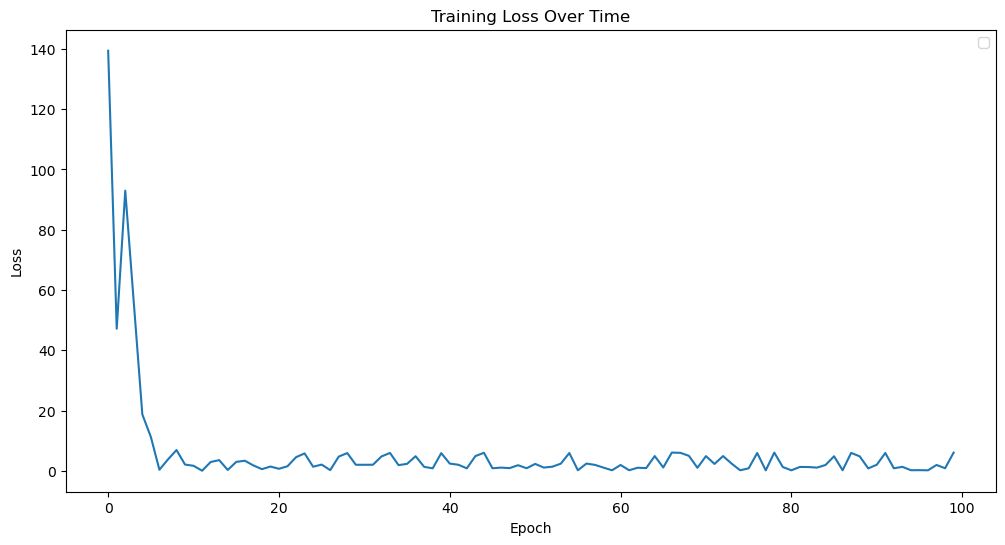

[35.5086  38.0418  43.4838  49.856   52.9288  57.8236  62.7077  66.5907
 69.7292  74.3549  78.7489  81.9309  83.38622 86.35764 91.43762]
Country ESP
Epoch number: 0 Training Loss: 9.7608 Test Loss: 17.3443
Epoch number: 10 Training Loss: 7.6689 Test Loss: 870.2680
Epoch number: 20 Training Loss: 14.5110 Test Loss: 774.8488
Epoch number: 30 Training Loss: 0.1814 Test Loss: 757.1621
Epoch number: 40 Training Loss: 4.7660 Test Loss: 752.5125
Epoch number: 50 Training Loss: 3.8194 Test Loss: 742.5330
Epoch number: 60 Training Loss: 25.7976 Test Loss: 741.4440
Epoch number: 70 Training Loss: 25.2172 Test Loss: 749.7111
Epoch number: 80 Training Loss: 0.8056 Test Loss: 749.8381
Epoch number: 90 Training Loss: 27.3164 Test Loss: 753.9962


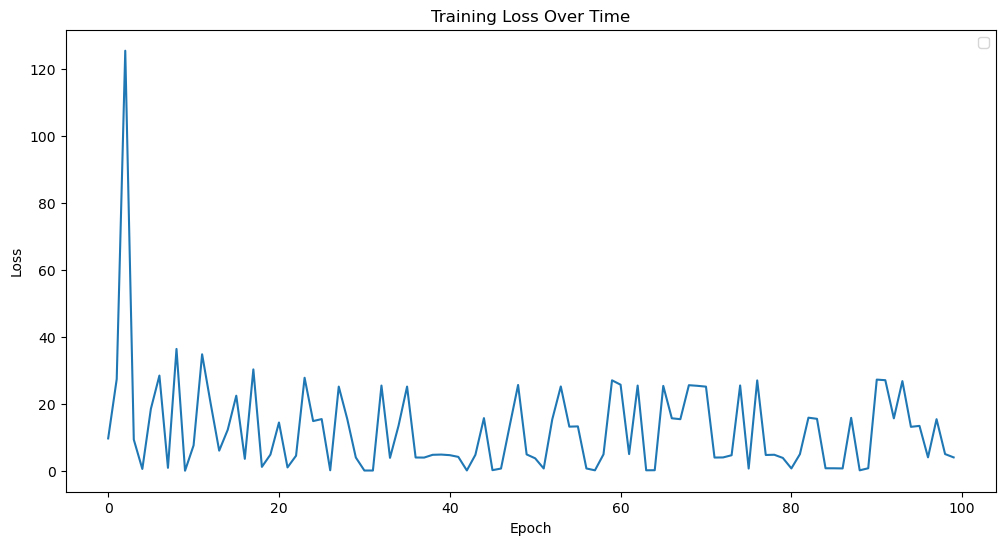

[31.4582   35.1534   39.6097   46.0427   47.8904   53.7319   57.9695
 61.0219   62.3417   64.8709   70.2348   74.0535   76.934963 79.42511
 80.93853 ]
Country PRT
Epoch number: 0 Training Loss: 0.9944 Test Loss: 293.8570
Epoch number: 10 Training Loss: 4.2949 Test Loss: 457.3196
Epoch number: 20 Training Loss: 5.1613 Test Loss: 506.2019
Epoch number: 30 Training Loss: 5.8611 Test Loss: 524.7208
Epoch number: 40 Training Loss: 6.0180 Test Loss: 528.8116
Epoch number: 50 Training Loss: 18.1832 Test Loss: 521.7390
Epoch number: 60 Training Loss: 6.0087 Test Loss: 528.6824
Epoch number: 70 Training Loss: 18.8986 Test Loss: 528.6624
Epoch number: 80 Training Loss: 6.0219 Test Loss: 528.9226
Epoch number: 90 Training Loss: 0.0021 Test Loss: 522.0825


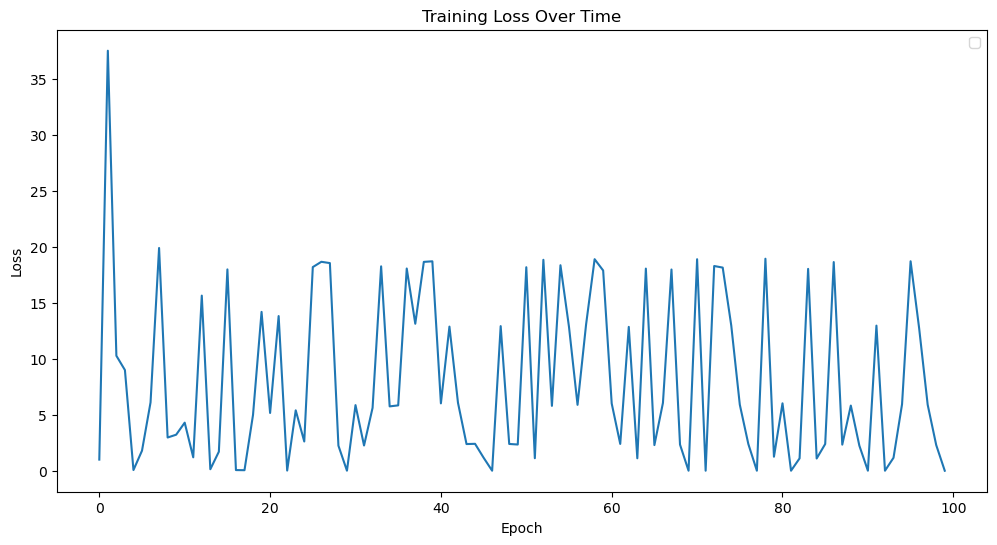

In [191]:
for i in range(1, len(ls), 8):
    a = df[df["LOCATION"] == ls[i]]["Value"].values
    print(a)
    split_idx = int(len(a) * 0.75)
    bucket = 3
    X_train, y_train = create_dataset(a[:split_idx], bucket)
    X_test, y_test = create_dataset(a[split_idx:], bucket)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=1, shuffle=False)
    print(f'Country {ls[i]}')
    losses = train(model, criterion, optimizer, train_loader, test_loader, epochs=100)
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()